# Import packages

In [1]:
import sys
sys.path.append('../src/')
from tools import get_coma_results, get_starmie_vectors, generate_ids_paths, columns_to_profiles, create_profiles_tensor, create_configuration
from graph import create_relatedness_graphs_from_silos
from train import negative_sampling_3
from train import train_model
from train import compute_all_probs_labels, compute_probabilities_labels, compute_starmie_probs_labels
from train import metrics
import pandas as pd
from sklearn.metrics import precision_recall_curve

import torch
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt

Using backend: pytorch


# Dataset preperation and profiling

In [2]:
path_to_datasets ="../datasets/ladata_silos/"
cols_to_ids, files_to_paths = generate_ids_paths(path_to_datasets)

## Profiling

### If not pre-computed

In [ ]:
cols_profiles = columns_to_profiles(files_to_paths)  # run this if profiles have not been pre-computed

### If pre-computed

In [3]:
profiles_file = '../profiles/ladata_profiles.pickle'
with open(profiles_file, 'rb') as file:
    cols_profiles= pickle.load(file)

In [4]:
profiles_tensor = create_profiles_tensor(cols_profiles, cols_to_ids)

# Construct relatedness graphs

## Configure silos

### Compute random configuration

In [ ]:
silo_configuration = create_configuration(cols_to_ids, 2, 2, 5, 'random') # construct 5 silos where we sample exactly 2 datasets per base table (base tables selected randomly)

### Load configuration from paper

In [5]:
configuration_file = '../configurations/la_silos.pickle'
with open(configuration_file, 'rb') as file:
    silo_configuration = pickle.load(file)

## Load ground truth of matches

In [6]:
matches_file = '../ground_truth/matches_ladata.csv'
matches_df = pd.read_csv(matches_file)

ground_truth = []
for index, row in matches_df.iterrows():
    ground_truth.append(((row['Dataset-1'][:-4], row['Column-1']), (row['Dataset-2'][:-4], row['Column-2'])))

## Construct relatedness graphs

In [7]:
graphs, all_columns, all_cols_ids, all_ids_cols = create_relatedness_graphs_from_silos(cols_to_ids, profiles_tensor.tolist(), ground_truth, silo_configuration)

## Get negative samples from all relatedness graphs

In [8]:
graphs_neg = dict()

for i in range(len(graphs)):
    graphs_neg[i] = negative_sampling_3(graphs[i]) # use negative sampling strategy #3 from the paper

# Train model

In [9]:
model = train_model(graphs, graphs_neg, 10, 256, incremental= True) # train incrementally for 10 epochs per relatedness graph

In epoch 0, loss 1.255948781967163, f1 0.407229483127594
In epoch 0, loss 0.8820712566375732, f1 0.891391396522522
In epoch 0, loss 0.5908398032188416, f1 0.8271400332450867
In epoch 0, loss 0.2230721414089203, f1 0.9357069730758667
In epoch 0, loss 0.08320332318544388, f1 0.9800296425819397
In epoch 0, loss 0.02463681437075138, f1 0.9963333010673523
In epoch 0, loss 0.06472212076187134, f1 0.9896312952041626
In epoch 0, loss 0.033498361706733704, f1 0.995550811290741
In epoch 0, loss 0.01621098816394806, f1 0.998602569103241
In epoch 0, loss 0.017087353393435478, f1 0.9983734488487244


## Embed all nodes based on the trained model

In [10]:
embeddings = dict()

for j in range(len(graphs)):

    embeddings[j] = model.gnn(graphs[j], graphs[j].ndata['feat']).detach()

## Compute precision and recall values for different thresholds

In [11]:
probabilities_sima, labels_sima, complete_results_sima = compute_all_probs_labels(all_columns, all_cols_ids, embeddings, ground_truth, model, len(graphs))
precision_sima, recall_sima, thresholds_sima = precision_recall_curve(probabilities_sima, labels_sima)    

Computing between graphs: 0 - 1
Computing between graphs: 0 - 2
Computing between graphs: 0 - 3
Computing between graphs: 0 - 4
Computing between graphs: 0 - 5
Computing between graphs: 0 - 6
Computing between graphs: 0 - 7
Computing between graphs: 0 - 8
Computing between graphs: 0 - 9
Computing between graphs: 1 - 2
Computing between graphs: 1 - 3
Computing between graphs: 1 - 4
Computing between graphs: 1 - 5
Computing between graphs: 1 - 6
Computing between graphs: 1 - 7
Computing between graphs: 1 - 8
Computing between graphs: 1 - 9
Computing between graphs: 2 - 3
Computing between graphs: 2 - 4
Computing between graphs: 2 - 5
Computing between graphs: 2 - 6
Computing between graphs: 2 - 7
Computing between graphs: 2 - 8
Computing between graphs: 2 - 9
Computing between graphs: 3 - 4
Computing between graphs: 3 - 5
Computing between graphs: 3 - 6
Computing between graphs: 3 - 7
Computing between graphs: 3 - 8
Computing between graphs: 3 - 9
Computing between graphs: 4 - 5
Computin

# Load COMA results

In [12]:
coma_results_file = '../coma_results/ladata_coma_results.json'
coma_results = get_coma_results(coma_results_file, all_cols_ids, {(c1, c2) for c1,c2,_ in complete_results_sima})

## Compute precision and recall values for different thresholds

In [13]:
labels_coma, probabilities_coma = compute_probabilities_labels(coma_results, ground_truth)
precision_coma, recall_coma, thresholds_coma = precision_recall_curve(labels_coma, probabilities_coma)

# Load Starmie results

## Load Starmie column vectors

In [14]:
embeddings_path = '../starmie_vectors/starmie_vectors_ladata.pkl'
vectors = get_starmie_vectors(path_to_datasets, embeddings_path)

## Compute precision and recall values for different thresholds

In [15]:
probabilities_starmie, labels_starmie = compute_starmie_probs_labels(all_columns, vectors, ground_truth, len(graphs))
precision_starmie, recall_starmie, thresholds_starmie = precision_recall_curve(probabilities_starmie, labels_starmie) 

Computing between graphs: 0 - 1
Computing between graphs: 0 - 2
Computing between graphs: 0 - 3
Computing between graphs: 0 - 4
Computing between graphs: 0 - 5
Computing between graphs: 0 - 6
Computing between graphs: 0 - 7
Computing between graphs: 0 - 8
Computing between graphs: 0 - 9
Computing between graphs: 1 - 2
Computing between graphs: 1 - 3
Computing between graphs: 1 - 4
Computing between graphs: 1 - 5
Computing between graphs: 1 - 6
Computing between graphs: 1 - 7
Computing between graphs: 1 - 8
Computing between graphs: 1 - 9
Computing between graphs: 2 - 3
Computing between graphs: 2 - 4
Computing between graphs: 2 - 5
Computing between graphs: 2 - 6
Computing between graphs: 2 - 7
Computing between graphs: 2 - 8
Computing between graphs: 2 - 9
Computing between graphs: 3 - 4
Computing between graphs: 3 - 5
Computing between graphs: 3 - 6
Computing between graphs: 3 - 7
Computing between graphs: 3 - 8
Computing between graphs: 3 - 9
Computing between graphs: 4 - 5
Computin

# Plot results

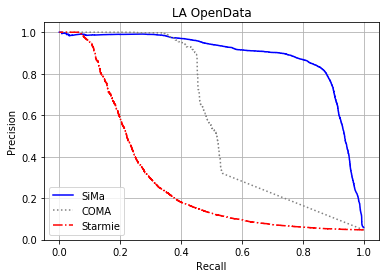

In [16]:
fig, ax = plt.subplots()

ax.plot(recall_sima, precision_sima, color='blue')

ax.plot(recall_coma, precision_coma, color = 'grey', linestyle='dotted')

ax.plot(recall_starmie, precision_starmie, color = 'red', linestyle='dashdot')

plt.legend(["SiMa", "COMA", "Starmie"], loc=0, frameon=True)

#add axis labels to plot
ax.set_title('LA OpenData')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.grid()
plt.show()